In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy import stats
%matplotlib inline 
import matplotlib.pyplot as plt

from bioinfokit import analys, visuz

In [2]:

script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
# rel_path_data_wt="WT_trimmed-sorted-bam.txt"
rel_path_data_wt="benoit-Processed-dataset-WildType1_pergene.txt"
rel_path_data_mutant="benoit-Processed-dataset-Dpl1del_pergene.txt"
# rel_path_data_mutant="dDpl1Kan-sorted-bam.txt"


abs_path_data_wt = os.path.join(script_dir, rel_path_data_wt)
abs_path_data_mutant = os.path.join(script_dir, rel_path_data_mutant)
data_wt = pd.read_csv(abs_path_data_wt, sep="\t", header=0)
data_mutant = pd.read_csv(abs_path_data_mutant, sep="\t", header=0)

# data_mutant.columns=['insertions','reads']
# data_wt.columns=['insertions','reads']

In [3]:
data_wt['number_of_read_pergene']=data_wt['number_of_transposon_per_gene']
data_wt['number_of_transposon_per_gene']=data_wt['gene_name']
data_wt['gene_name']=data_wt.index
data_wt.index=np.arange(0,len(data_wt))

In [4]:
data_mutant['number_of_read_pergene']=data_mutant['number_of_transposon_per_gene']
data_mutant['number_of_transposon_per_gene']=data_mutant['gene_name']
data_mutant['gene_name']=data_mutant.index
data_mutant.index=np.arange(0,len(data_mutant))

In [5]:
data_mutant.columns=['geneid','insertions','reads']
data_wt.columns=['geneid','insertions','reads']

In [6]:
total_tn_mutant=data_mutant.insertions.sum()
total_tn_wt=data_wt.insertions.sum()

In [7]:
data_mutant_normalized2tn=data_mutant.insertions/total_tn_mutant
data_wt_normalized2tn=data_wt.insertions/total_tn_wt

In [8]:
fold_change_per_gene=data_mutant_normalized2tn/data_wt_normalized2tn

In [9]:
data2volcano=pd.DataFrame(columns=['geneid','values-exp','values-ref','log2FC','p-value'])

In [10]:
fold_change_per_gene

0       1.016231
1       2.328864
2       0.465773
3       1.397318
4       1.019665
          ...   
6598    1.571983
6599    1.130184
6600    0.877205
6601    0.613973
6602    0.931546
Name: insertions, Length: 6603, dtype: float64

In [12]:
data2volcano['geneid']=data_wt['geneid']
data2volcano['values-exp']=data_mutant_normalized2tn
data2volcano['values-ref']=data_wt_normalized2tn
data2volcano['log2FC']=np.log2(fold_change_per_gene)
data2volcano['log2FC'].fillna(0)
data2volcano['values-ref'].fillna(0)
data2volcano['values-exp'].fillna(0)
data2volcano['log2FC']=data2volcano['log2FC'].replace(to_replace='-inf',value=0)

## p-value according a T-student distribution

- https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f
- https://www.reneshbedre.com/blog/volcano.html

In [22]:

## Define 2 random distributions
#Sample Size
N = len(data2volcano)
#Gaussian distributed data with mean = 2 and var = 1
a = data2volcano['values-exp'].fillna(0)
#Gaussian distributed data with with mean = 0 and var = 1
b = data2volcano['values-ref'].fillna(0)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)

## Calculate the t-statistics
t = (a - b)/(s*np.sqrt(2/N))


## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


# print("t = " + str(t))
# print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
# print("t = " + str(t2))
# print("p = " + str(p2))

In [26]:
data2volcano['p-value']=p
data2volcano['ttest']=t

(array([3.000e+00, 1.400e+01, 8.400e+01, 1.324e+03, 4.880e+03, 2.710e+02,
        1.300e+01, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([-141.63018633, -108.25807165,  -74.88595696,  -41.51384228,
          -8.14172759,   25.23038709,   58.60250178,   91.97461646,
         125.34673115,  158.71884584,  192.09096052]),
 <a list of 10 Patch objects>)

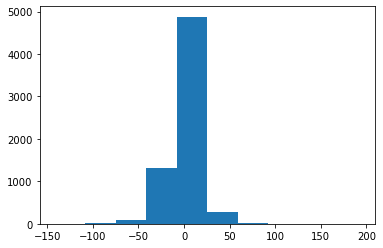

In [23]:
plt.hist(data2volcano['ttest'])

In [30]:
inf=data2volcano['log2FC'][6599]
data2volcano['log2FC']=data2volcano['log2FC'].replace(inf,0)
data2volcano['log2FC']=data2volcano['log2FC'].fillna(0)
data2volcano['log2FC']=pd.to_numeric(data2volcano['log2FC'])
data2volcano['p-value']=data2volcano['p-value'].fillna(0)
data2volcano['p-value']=pd.to_numeric(data2volcano['p-value'])

In [47]:
visuz.gene_exp.volcano(df=data2volcano, lfc='log2FC', pv='p-value',pv_thr=[1, 1],geneid='geneid',genenames=('CDC24','CDC42'))

In [49]:
visuz.gene_exp.volcano(df=data2volcano, lfc='log2FC', pv='p-value', plotlegend=True, legendpos='upper right', 
    legendanchor=(1.46,1),pv_thr=[0.99,0.99],sign_line=True)